In [31]:
import pandas as pd
import numpy as np
from itertools import permutations
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score
from scipy.spatial.distance import pdist, squareform

In [32]:
df = pd.read_csv('data/user_ratings.csv')
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [67]:
df.shape

(100836, 6)

In [34]:
df.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64

## Non-personalized recommendation

In [35]:
movie_popularity = df['title'].value_counts()
movie_popularity.head().index

Index(['Forrest Gump (1994)', 'Shawshank Redemption, The (1994)',
       'Pulp Fiction (1994)', 'Silence of the Lambs, The (1991)',
       'Matrix, The (1999)'],
      dtype='object')

In [36]:
avg_rating_df = df[['title', 'rating']].groupby('title').mean()
sorted_avg_ratings = avg_rating_df.sort_values(by='rating', ascending=False)
sorted_avg_ratings.head()

,rating
title,
Gena the Crocodile (1969),5.0
True Stories (1986),5.0
Cosmic Scrat-tastrophe (2015),5.0
Love and Pigeons (1985),5.0
Red Sorghum (Hong gao liang) (1987),5.0


In [37]:
popular_movies = movie_popularity[movie_popularity > 50].index
popular_movies

Index(['Forrest Gump (1994)', 'Shawshank Redemption, The (1994)',
       'Pulp Fiction (1994)', 'Silence of the Lambs, The (1991)',
       'Matrix, The (1999)', 'Star Wars: Episode IV - A New Hope (1977)',
       'Jurassic Park (1993)', 'Braveheart (1995)',
       'Terminator 2: Judgment Day (1991)', 'Schindler's List (1993)',
       ...
       'Chasing Amy (1997)', 'Mystic River (2003)',
       'Grand Budapest Hotel, The (2014)', 'Blow (2001)',
       'Army of Darkness (1993)', 'Training Day (2001)', 'Bad Boys (1995)',
       'Splash (1984)', 'Mulholland Drive (2001)',
       'The Devil's Advocate (1997)'],
      dtype='object', length=437)

In [38]:
popular_movies_rankings = df[df['title'].isin(popular_movies)]
popular_movies_rankings.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [39]:
popular_movies_avg_rankings = popular_movies_rankings[['title', 'rating']].groupby('title').mean()
popular_movies_avg_rankings.sort_values(by='rating', ascending=False).head()

,rating
title,
"Shawshank Redemption, The (1994)",4.429022
"Godfather, The (1972)",4.289062
Fight Club (1999),4.272936
Cool Hand Luke (1967),4.271930
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964),4.268041


## Finding all pairs of movies

In [40]:
def find_movie_pairs(x):
    pairs = pd.DataFrame(list(permutations(x.values, 2)), columns=['movie_a', 'movie_b'])
    return pairs

movie_combinations = df.groupby('userId')['title'].apply(find_movie_pairs)
movie_combinations.head()

movie_a                      movie_b
userId                                                 
1      0  Toy Story (1995)      Grumpier Old Men (1995)
       1  Toy Story (1995)                  Heat (1995)
       2  Toy Story (1995)  Seven (a.k.a. Se7en) (1995)
       3  Toy Story (1995)   Usual Suspects, The (1995)
       4  Toy Story (1995)   From Dusk Till Dawn (1996)

In [41]:
movie_combinations = movie_combinations.reset_index(drop=True)
movie_combinations.head()

,movie_a,movie_b
0,Toy Story (1995),Grumpier Old Men (1995)
1,Toy Story (1995),Heat (1995)
2,Toy Story (1995),Seven (a.k.a. Se7en) (1995)
3,Toy Story (1995),"Usual Suspects, The (1995)"
4,Toy Story (1995),From Dusk Till Dawn (1996)


In [42]:
combination_counts = movie_combinations.groupby(['movie_a', 'movie_b']).size()
combination_counts.head()

movie_a     movie_b                                   
'71 (2014)  (500) Days of Summer (2009)                   1
            10 Cloverfield Lane (2016)                    1
            127 Hours (2010)                              1
            13 Assassins (Jûsan-nin no shikaku) (2010)    1
            13 Hours (2016)                               1
dtype: int64

In [43]:
combination_counts_df = combination_counts.to_frame(name='size').reset_index()
combination_counts_df.sort_values(by='size', ascending=False, inplace=True)
combination_counts_df.head()

,movie_a,movie_b,size
20672049,"Shawshank Redemption, The (1994)",Forrest Gump (1994),231
8538313,Forrest Gump (1994),"Shawshank Redemption, The (1994)",231
8537603,Forrest Gump (1994),Pulp Fiction (1994),230
18567035,Pulp Fiction (1994),Forrest Gump (1994),230
20675275,"Shawshank Redemption, The (1994)",Pulp Fiction (1994),222


In [44]:
mystic_df = combination_counts_df[combination_counts_df['movie_a'] == 'Mystic River (2003)']
mystic_df.head()

,movie_a,movie_b,size
16203519,Mystic River (2003),Fight Club (1999),45
16205344,Mystic River (2003),"Matrix, The (1999)",44
16206350,Mystic River (2003),Pulp Fiction (1994),44
16203631,Mystic River (2003),Forrest Gump (1994),44
16206864,Mystic River (2003),"Shawshank Redemption, The (1994)",43


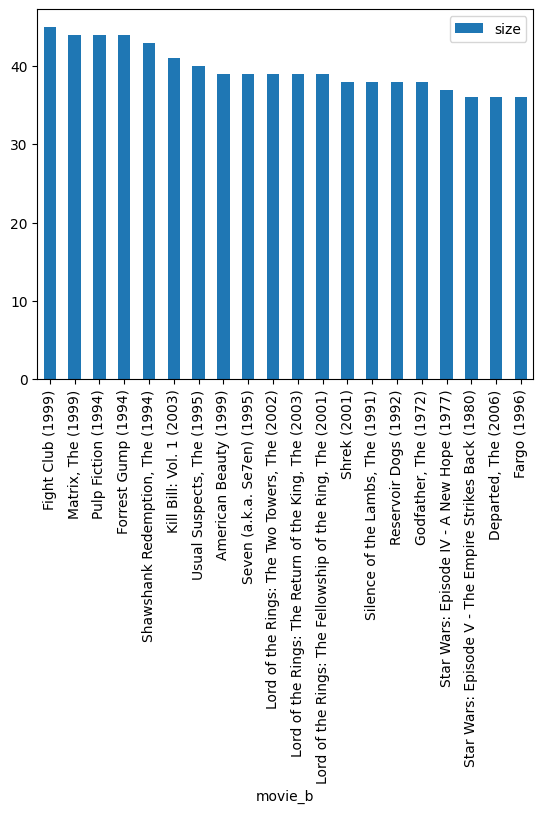

In [45]:
mystic_df.head(20).plot.bar(x='movie_b')
plt.show()

## Content based recommendation

In [54]:
movie_genre = df[['title', 'genres']]
movie_genre.head()

,title,genres
0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [55]:
movie_genre.shape

(100836, 2)

In [57]:
movie_list = df['genres'].str.split('|')
movie_genre.genres = movie_list
movie_genre.head()

C:\Users\USER\AppData\Local\Temp\ipykernel_7188\183812519.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_genre.genres = movie_list


,title,genres
0,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
2,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
3,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
4,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"


In [58]:
movie_genre = movie_genre.explode('genres').reset_index(drop=True)
movie_genre.head()

,title,genres
0,Toy Story (1995),Adventure
1,Toy Story (1995),Animation
2,Toy Story (1995),Children
3,Toy Story (1995),Comedy
4,Toy Story (1995),Fantasy


In [59]:
movie_genre.shape

(274480, 2)

In [63]:
movie_genre.genres.value_counts()

Drama                 41928
Comedy                39053
Action                30635
Thriller              26452
Adventure             24161
Romance               18124
Sci-Fi                17243
Crime                 16681
Fantasy               11834
Children               9208
Mystery                7674
Horror                 7291
Animation              6988
War                    4859
IMAX                   4145
Musical                4138
Western                1930
Documentary            1219
Film-Noir               870
(no genres listed)       47
Name: genres, dtype: int64

In [60]:
movie_cross_table = pd.crosstab(movie_genre['title'], movie_genre['genres'])
movie_cross_table.head()

genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
title,,,,,,,,,,,,,,,,,,,,
'71 (2014),0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0
'Hellboy': The Seeds of Creation (2004),0,1,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0
'Round Midnight (1986),0,0,0,0,0,0,0,0,2,0,0,0,0,2,0,0,0,0,0,0
'Salem's Lot (2004),0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0
'Til There Was You (1997),0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,0,0,0,0


In [68]:
toy_story_genres_ct = movie_cross_table[movie_cross_table.index == 'Toy Story (1995)']
toy_story_genres_ct

genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
title,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),0,0,215,215,215,215,0,0,0,215,0,0,0,0,0,0,0,0,0,0


In [79]:
toy_story = movie_cross_table.loc['Toy Story (1995)'].values
zulu = movie_cross_table.loc['Zulu (2013)'].values
jaccard_score(toy_story, zulu, average='weighted')

0.45

In [80]:
jaccard_distances = pdist(movie_cross_table.values, metric='jaccard')
jaccard_similarity_array = 1 - squareform(jaccard_distances)
jaccard_similarity_df = pd.DataFrame(jaccard_similarity_array, index=movie_cross_table.index, 
                                     columns=movie_cross_table.index)
jaccard_similarity_df.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.000000,0.125,0.000000,0.333333,0.000000,0.0,0.0,0.25,0.0,0.0,...,0.4,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.000000
'Hellboy': The Seeds of Creation (2004),0.125000,1.000,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667
'Round Midnight (1986),0.000000,0.000,1.000000,0.000000,0.333333,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
'Salem's Lot (2004),0.333333,0.000,0.000000,1.000000,0.000000,0.0,0.0,0.25,0.0,0.0,...,0.4,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.000000
'Til There Was You (1997),0.000000,0.000,0.333333,0.000000,1.000000,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [82]:
jaccard_similarity_series = jaccard_similarity_df.loc["'71 (2014)"]
ordered_similarities = jaccard_similarity_series.sort_values(ascending=False)
ordered_similarities

title
'71 (2014)                                                         1.00
Army of Shadows (L'armée des ombres) (1969)                        1.00
Battle Royale 2: Requiem (Batoru rowaiaru II: Chinkonka) (2003)    1.00
Seeking Justice (2011)                                             0.75
New One-Armed Swordsman, The (Xin du bi dao) (1971)                0.75
                                                                   ... 
Jeremiah Johnson (1972)                                            0.00
Jennifer's Body (2009)                                             0.00
Jennifer 8 (1992)                                                  0.00
Jeffrey (1995)                                                     0.00
À nous la liberté (Freedom for Us) (1931)                          0.00
Name: '71 (2014), Length: 9719, dtype: float64

## Collaborative filtering

In [51]:
user_ratings = df[['userId', 'title', 'rating']]
user_ratings.head()

,userId,title,rating
0,1,Toy Story (1995),4.0
1,5,Toy Story (1995),4.0
2,7,Toy Story (1995),4.5
3,15,Toy Story (1995),2.5
4,17,Toy Story (1995),4.5


In [85]:
user_ratings_table = user_ratings.pivot(index='userId', columns='title', values='rating')
print(user_ratings_table)

ValueError: Index contains duplicate entries, cannot reshape

In [ ]:
user_ratings.userId.value_counts()

In [ ]:
user_ratings.shape